In [30]:
from typing import Annotated
from dotenv import load_dotenv
from typing_extensions import TypedDict
import os


In [6]:
from langchain_community.utilities import ArxivAPIWrapper, WikipediaAPIWrapper
from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun

arxiv_wrapper = ArxivAPIWrapper(top_k_results=1, doc_content_chars_max=30)
arxiv_tool= ArxivQueryRun(api_wrapper=arxiv_wrapper)

api_wrapper=WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=30)
wiki_tool=WikipediaQueryRun(api_wrapper=api_wrapper)

In [11]:
wiki_tool.invoke("Who is Sharukh Khan")

'Page: Shah Rukh Khan\nSummary: '

In [12]:
arxiv_tool.invoke("Attention is all you need")

'Published: 2024-07-22\nTitle: A'

In [13]:
tools=[wiki_tool]

In [15]:
from langgraph.graph.message import add_messages
#Langgraph App
class State (TypedDict):
    messages:Annotated[list, add_messages]


In [16]:
from langgraph.graph import StateGraph, START, END

In [17]:
graph_builder = StateGraph(State)

In [31]:
from langchain_groq import ChatGroq
load_dotenv()
groq_api_key = os.getenv("groq_KEY")
print(groq_api_key)

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


In [32]:
llm = ChatGroq(groq_api_key=groq_api_key, model_name="Gemma2-9b-It")

In [33]:
llm_with_tools = llm.bind_tools(tools=tools)

In [34]:
def chatbot(state:State):
    return {"message": [llm_with_tools.invoke(state["messages"])]}

In [35]:
from langgraph.prebuilt import ToolNode, tools_condition

In [36]:
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_edge(START, "chatbot")
tool_node = ToolNode(tools=tools)

graph_builder.add_node("tools", tool_node)
graph_builder.add_conditional_edges(
    "chatbot", tools_condition
)
graph_builder.add_edge("tools","chatbot" )
graph_builder.add_edge("chatbot", END)

In [37]:
graph = graph_builder.compile()

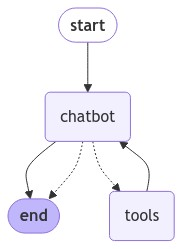

In [38]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [ ]:
user_input = "Hi There! Myname is Ranjit"

events=graph.stream(
    {"messages":[("user",user_input)]} , stream_mode="values"
)

for event in events:
    event["messages"][-1].pretty_print()